In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


[24437.1  62824.19 62440.91 ... 14214.   14387.   14639.  ]


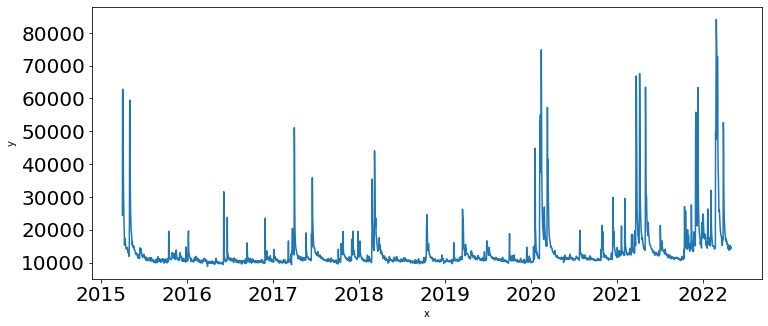

In [47]:
# Prepare DATA
RED_obs = pd.read_csv("RED_Observed.csv")
RED_BOM = pd.read_csv("RED_Rainfall.csv")

# Set date as index and convert to datetime
RED_obs.set_index('Date',inplace=True)
RED_obs.index = pd.to_datetime(RED_obs.index, infer_datetime_format=True).astype('datetime64[ns]')

# Convert columns to numbers
RED_obs['Rainfall'] = pd.to_numeric(RED_obs['Rainfall'], errors='coerce')
RED_obs['Inflow'] = pd.to_numeric(RED_obs['Inflow'], errors='coerce')
RED_obs['Inflow'].fillna(method='ffill', inplace=True)

# Convert date columns to a single datetime and set as index then remove the leftover columns
RED_BOM['Date'] = pd.to_datetime(RED_BOM[['Year','Month','Day']])
RED_BOM.set_index('Date',inplace=True)
RED_BOM.drop(['Year','Month','Day', 'Period over which rainfall was measured (days)', 'Quality'], axis=1, inplace=True)

RED_BOM.rename(columns = {'Rainfall amount (millimetres)': 'Rainfall'},inplace=True)
RED_BOM.dropna(inplace=True)

# Combine the RED_BOM and RED_obs into one df

df = RED_obs.join(RED_BOM, lsuffix='_obs', rsuffix='_BOM') # Left Join on RED_obs
df['Rainfall_BOM'].fillna(method='ffill', inplace=True)
df.dropna(inplace=True)


# Create generic x, y from flows 
dates = df.index.values
N = len(df['Inflow'])
x = df.index.values
y = df['Inflow'].values.astype(np.float32)

print(y)

plt.figure(figsize=(12,5))
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y)

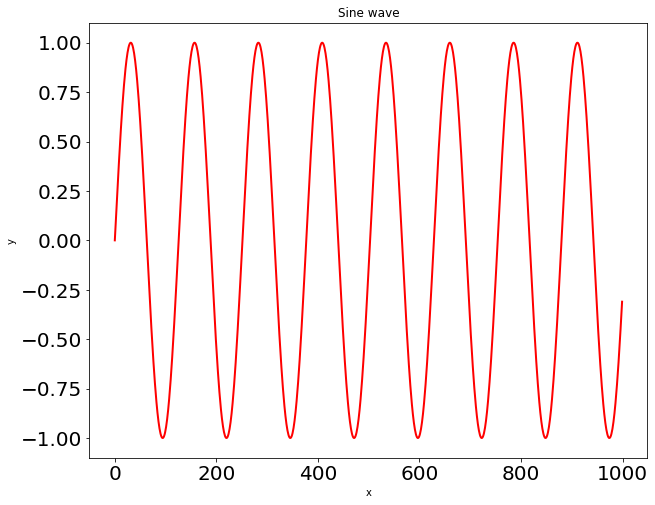

In [234]:
# Generate some easy data for testing the model is training correctly

N = 1
L = 1000
T = 20


x = np.empty(L, np.float32)
x = np.array(range(L))
x = np.array(range(L))
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize = (10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[0]), y[:],'r', linewidth=2.0)
plt.show()

In [309]:
# Setup CPU
device = torch.device("cpu")

In [3]:
# Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [229]:
# DEPRECATED Convert data set to tensors (LSTMCell)
num_train = 365 # How many training samples to use
num_test = 100 # How many training samples to use

train_data = y[:num_train]
train_target = y[1:num_train+1]

test_data = y[num_train:num_train+num_test]
test_target = y[num_train+1:num_train+num_test+1]

train_input = torch.tensor(train_data)
test_input = torch.tensor(test_data)

train_target = torch.tensor(train_target)
test_target = torch.tensor(test_target)

print(train_input.shape)


torch.Size([365])


In [36]:
def log_and_norm(data):
    # Log transofrm
    data = np.log(data)
    # min-max normalization
    data = (data-min(data))/(max(data)-min(data))

    return data

In [48]:
# Convert data set to tensors (LSTM)
split_frac = 0.7
num_train = round(split_frac * len(y))# How many training samples to use
num_test = round((1-split_frac) * len(y)) # How many training samples to use
future = 365

# training data
train_data = y[:num_train-1]
train_target = y[1:num_train]

# log transform and normalize
train_data = log_and_norm(train_data)
train_target = log_and_norm(train_target)

# testing data
test_data = y[num_train-1:num_train+num_test-1]
test_target = y[num_train:num_train+num_test]

# log transform and normalize
test_data = log_and_norm(test_data)
test_target = log_and_norm(test_target)

# Convert to tensors
train_input = torch.tensor(train_data).unsqueeze(-1)
test_input = torch.tensor(test_data[:-future]).unsqueeze(-1)

train_target = torch.tensor(train_target).unsqueeze(-1)
test_target = torch.tensor(test_target[:-future]).unsqueeze(-1)


if torch.cuda.is_available():
    train_input = train_input.to(device)
    test_input = test_input.to(device)
    train_target = train_target.to(device)
    test_target = test_target.to(device)

print(num_train, len(test_target), len(y))

1802 408 2575


In [4]:
# DEPRECATED LSTM Class (LSTMCell)

class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()

        self.n_hidden = n_hidden
        
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []

        # Initialize hidden and cell states
        h_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)

        # Propagate input through LSTM
        for input_t in x.split(1, dim=0):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # Propogate input through LSTM for future values
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # Convert list to tensor
        outputs = torch.cat(outputs, dim=0)
        return outputs



In [8]:
# LSTM Class 2

class LSTMPredictor2(nn.Module):
    def __init__(self, device, input_dim=1, n_layers=2, hidden_dim=51, ):
        super(LSTMPredictor2, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        
        # stacked lstm, linear
        self.lstm = nn.LSTM(1, self.hidden_dim, self.n_layers)
        self.Linear = nn.Linear(self.hidden_dim, 1)


    def forward(self, x, future=0):
        outputs = []

        # Initialize hidden and cell states
        h0 = torch.zeros(self.n_layers, self.hidden_dim)
        c0 = torch.zeros(self.n_layers, self.hidden_dim)

        if torch.cuda.is_available():
            h0 = h0.to(self.device)
            c0 = c0.to(self.device)
        
        # Propagate input through LSTM
        for input_t in x.split(1, dim=0):
            lstm_out, (h0, c0) = self.lstm(input_t, (h0, c0))
            output = self.Linear(lstm_out)
            outputs.append(output)

        # Propogate input through LSTM for future values
        for i in range(future):
            lstm_out, (h0, c0) = self.lstm(output, (h0, c0))
            output = self.Linear(lstm_out)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=0)
        return outputs

        

In [72]:
# Initialize model
# model = LSTMPredictor()
model = LSTMPredictor2(device, input_dim=1, n_layers=10, hidden_dim=64)
if torch.cuda.is_available():
    model = model.to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.LBFGS(model.parameters(), lr=0.8)
test_losses = {}
train_losses = {}

In [73]:
# Training loop

epochs = 1000
for i in range(epochs):
    print("Epoch", i+1)

    # Train model
    def closure():
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = criterion(outputs, train_target)
        print("loss", loss.item())
        train_losses[i] = loss.item()
        loss.backward()
        return loss

    optimizer.step(closure)


    # Evaluate model
    with torch.no_grad():
        pred = model(test_input, future=future)
        loss = criterion(pred[:-future], test_target)
        print("test loss", loss.item())
        y = pred.detach().cpu().numpy()
    
    test_losses[i] = loss.item()

    if i==0 or (i+1) % 100 == 0:
        # Plot the prediction
        plt.figure(figsize=(12,5))
        plt.title(f"Step: {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        n = train_input.shape[0] # 2475
        ntest = test_input.shape[0] # 100

        # Draw original data
        plt.plot(np.arange(n), train_data, 'r', linewidth=2.0)
        plt.plot(np.arange(n, n + ntest), test_data[:-future], 'b', linewidth=2.0)
        plt.plot(np.arange(n + ntest, n + ntest + future ), test_data[-future:])
        # Draw new model data
        plt.plot(np.arange(n, n + ntest + future), y, 'g', linewidth=2.0)
        plt.savefig(f"images/10_layers/step{i+1}.png")
        plt.close()

Epoch 1
loss 0.06348083168268204
test loss 0.05088351294398308
Epoch 2
loss 0.04945757985115051
test loss 0.039440203458070755
Epoch 3
loss 0.03751493990421295
test loss 0.030044542625546455
Epoch 4
loss 0.02761596255004406
test loss 0.022899512201547623
Epoch 5
loss 0.019954603165388107
test loss 0.018486082553863525
Epoch 6
loss 0.015005137771368027
test loss 0.017646189779043198
Epoch 7
loss 0.01361570879817009
test loss 0.020701931789517403
Epoch 8
loss 0.016189388930797577
test loss 0.023621616885066032
Epoch 9
loss 0.018889715895056725
test loss 0.023755114525556564
Epoch 10
loss 0.019019369035959244
test loss 0.02218184433877468
Epoch 11
loss 0.01756139099597931
test loss 0.020290693268179893
Epoch 12
loss 0.01584102399647236
test loss 0.018787190318107605
Epoch 13
loss 0.014524144120514393
test loss 0.017844144254922867
Epoch 14
loss 0.013760417699813843
test loss 0.017384571954607964
Epoch 15
loss 0.013460757210850716
test loss 0.017258672043681145
Epoch 16
loss 0.013470012694

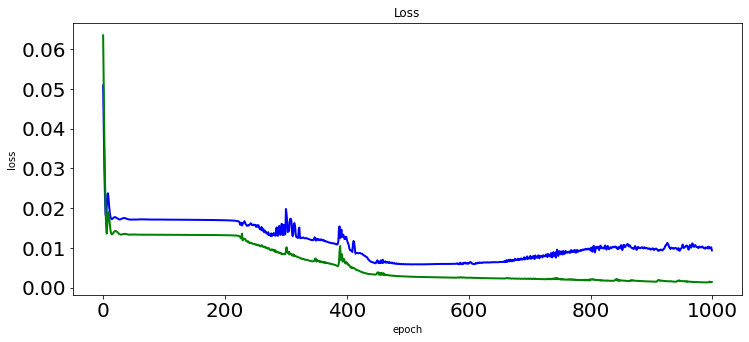

In [74]:
# Losses plot
losses1 = pd.DataFrame([test_losses]).T
losses1.columns = ["test"]
losses2 = pd.DataFrame([train_losses]).T
losses2.columns = ["train"]

plt.figure(figsize=(12,5))
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(losses1.index, losses1["test"], 'b', linewidth=2.0)
plt.plot(losses2.index, losses2['train'], 'g', linewidth=2.0)

In [75]:
# Save model
torch.save(model.state_dict(),'model_saves\\10_layer_lstm.pt')